# Energy data hack 
Challenge 1 : Interception des ondes radios sur les capteurs d’énergies


## Partie 4 : Finalisation et résultats

# Membres : 
- Maxence Brugères (Telecom Paris & Sciences Po)
- Clément Bernard (Telecom Paris & Polytechnique Montréal)
- Inès Benito (ENSTA Bretagne)
- Corentin Lestrat (ENSTA BRETAGNE)



![picture](https://github.com/clementbernardd/hackaton_ondes/raw/main/logo_hackaton.png)

# Importation of data and models 

In [1]:
# Obtention des données 
!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/Hackaton.zip
!unzip  Hackaton.zip
!rm Hackaton.zip

!wget https://github.com/clementbernardd/hackaton_ondes/raw/main/python.zip
!unzip python.zip
!rm python.zip

import sys
sys.path.append('/content/Hackaton/python')
sys.path.append('/content/python')
from read_pics import  * 
# Python file importations 
from utils import * 

import os 
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn 
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.cluster import AgglomerativeClustering



# Device to use : either gpu or cpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

--2021-04-05 00:04:39--  https://github.com/clementbernardd/hackaton_ondes/raw/main/Hackaton.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/clementbernardd/hackaton_ondes/main/Hackaton.zip [following]
--2021-04-05 00:04:39--  https://raw.githubusercontent.com/clementbernardd/hackaton_ondes/main/Hackaton.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13275917 (13M) [application/zip]
Saving to: ‘Hackaton.zip’

Hackaton.zip        100%[===================>]  12.66M  34.8MB/s    in 0.4s    

2021-04-05 00:04:40 (34.8 MB/s) - ‘Hackaton.zip’ saved [13275917/13275917]

Archive:  Hackaton.zip


## Charge le login et mdp 

In [2]:
pics_login, info = get_pics_from_file(os.path.join('Hackaton', 'data','pics_LOGINMDP.bin'))

## Dictionnaire pour mapper les lettres/caracteres aux classes

In [3]:
def letter_range(start, stop="{", step=1):
    for ord_ in range(ord(start.upper()), ord(stop.upper())+1, step):
        yield chr(ord_)
        
keys = ['NOKEY','0','1','2','3','4','5','6','7','8','9'] + list(letter_range("A", "Z")) + ['ENTER','CTRL','SHIFT','SPACE','SUPPR']
class_to_letter = {i : keys[i] for i in range(len(keys)) }
letter_to_class = {class_to_letter[i] : i for i in class_to_letter}
name_to_class = {'pics_'+letter+'.bin' : letter_to_class[letter] for letter in letter_to_class}

## Convertit les donnees en X et Y 

In [4]:
def get_data(name_to_class = name_to_class) : 
  ''' Return training dataset '''
  data = []
  labels = []
  for name in name_to_class : 
    
    pics, info = get_pics_from_file(os.path.join('Hackaton','data', name))
    for trame in pics : 
      data.append(trame)
      labels.append(name_to_class[name])      

  return np.array(data), np.array(labels)

In [5]:
data, labels = get_data()

In [6]:
train_data, train_labels, validation_data, validation_labels = split_data(data, labels )

# Random forest 

In [7]:
rf_clf = RandomForestClassifier(n_estimators= 400, max_depth = 20) 

In [8]:
rf_clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Prediction sur login et mdp

In [9]:
y_test = rf_clf.predict(np.array(pics_login))
y_test_proba = rf_clf.predict_proba(np.array(pics_login))

# Decoder 

In [10]:
class Analyser_single_trame:
    def __init__(self, classifier_, loginmdp_, x_test_, y_test_, loginmdp_predict_probas_=None, keys_=keys):
        self.classifier = classifier_
        self.confusion_matrix=confusion_matrix(y_test_,self.classifier.predict(x_test_).astype('int64'), normalize = 'true')
        self.x_test = x_test_
        self.y_test = y_test_
        self.keys = keys_
        self.bins = None 
        self.loginmdp = loginmdp_
        
        if loginmdp_predict_probas_ is None:
            self.loginmdp_predict_probas = self.classifier.predict_proba(self.loginmdp)
        else:
            self.loginmdp_predict_probas = loginmdp_predict_probas_

    
    def setBins(new_bins):
        self.bins=new_bins
    
    def decode_mdp(self, top_=-1):
        top = top_
        if top==-1:
            top=42
        res=[]
        for row in self.bins:
            ## Get average classification probabilities for each signal (17 spikes) that appears in the bin, 
            ## then average the proba over all those signals
            loginmdp_y_proba = self.get_average_proba_over_sequence(start=row[0], end=row[1])
           
            ## Get the distances between the previous probabilities and all the rows of the confusion matrix
            patern_proba_dist = self.get_distance_conf_matrix__prediction(loginmdp_y_proba)

            ## Find the 5 minimum distances and the corresponding keys
            focus_proba = (np.array(self.keys)[np.argsort(patern_proba_dist)[:top]]).tolist()
            patern_proba_dist_short = (np.sort(patern_proba_dist)[:top]).tolist()

            res.append([focus_proba,patern_proba_dist_short])

        return res

        
    def get_average_proba_over_sequence(self,start=None,end=None, y_pred=None):
        if y_pred is None:
            Y=self.loginmdp_predict_probas
        else:
            Y=y_pred
        if end==None:
            END = Y.shape[0]
        else:
            END = end
        if start==None:
            START = 0
        else:
            START = start
        return np.mean(Y[START:END], axis=0)

    def get_distance_conf_matrix__prediction(self, loginmdp_y_proba):
        res = []
        for row in self.confusion_matrix:
            res.append(np.linalg.norm(row-loginmdp_y_proba))
        return res

    def plot_prediction_proba(self, y_pred_=None, start=0, end = None, nbins_x=50,nbins_y=21 , shapeW=30, shapeH=10) : 
        if y_pred_ is None:
            y_pred=self.loginmdp_predict_probas
        else:
            y_pred=y_pred_
        if end==None:
            END = y_pred.shape[0]
        else:
            END = end
        START = start

        plt.figure(figsize = (shapeW,shapeH))
        im = plt.imshow(np.flip(np.rot90(y_pred),0), aspect = 'auto', interpolation='none', origin='lower', cmap='viridis')
        ax = plt.gca()
        ax.set_xlabel('Numéro de trame')
        ax.set_ylabel('Probabilité d\'appartenance à une touche pressée')
        plt.locator_params(axis="x", nbins=nbins_x)
        plt.locator_params(axis="y", nbins=nbins_y)
        plt.colorbar()
        plt.xlim(START,END)
        plt.show()
        
    def plot_confusion_mat(self, h=10, w=14, b=1):
        a = self.confusion_matrix

        fig, ax = plt.subplots(figsize = (14,10))
        plt.locator_params(axis="y", nbins=self.loginmdp_predict_probas.shape[1]//b)
        plt.locator_params(axis="x", nbins=self.loginmdp_predict_probas.shape[1]//b)
        im = plt.imshow(a, cmap='viridis')
        cbar = ax.figure.colorbar(im, ax=ax)

        fig.tight_layout()
        plt.show()


In [11]:
analyser = Analyser_single_trame(classifier_=rf_clf, loginmdp_=pics_login, x_test_= validation_data , y_test_=validation_labels)

## Affiche les probas pour chaque trame

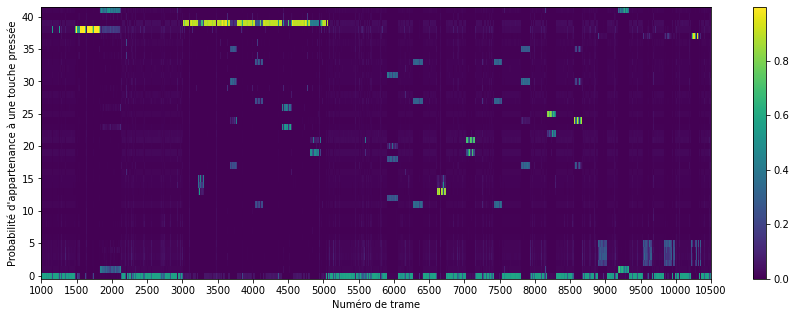

In [12]:
analyser.plot_prediction_proba(start=1000, end = 10500, shapeW=15, shapeH=5, nbins_y=12, nbins_x = 20)

## Retourne la matrice de confusion

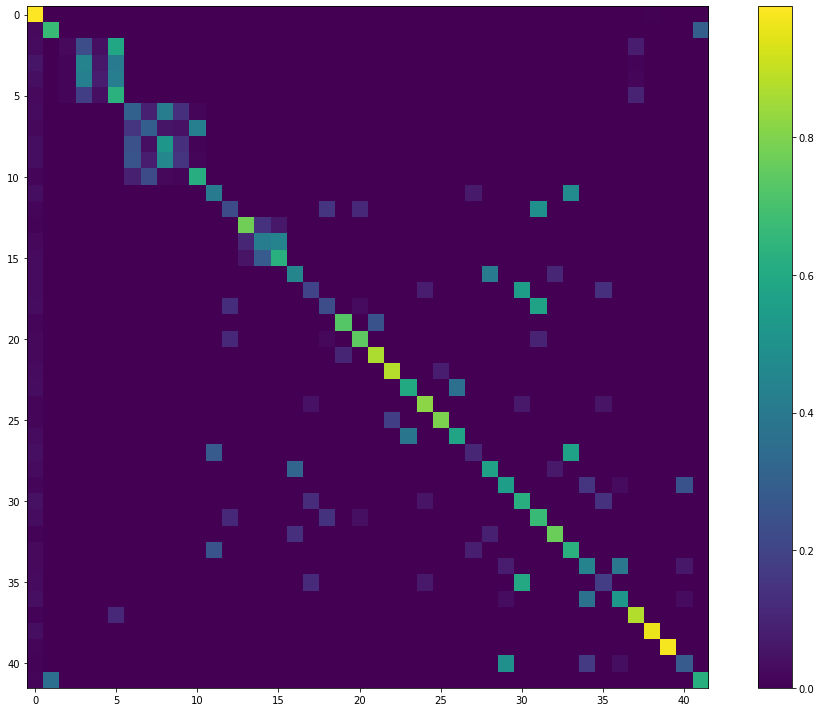

In [13]:
analyser.plot_confusion_mat(5,1,4)

## Retourne les pics montrant les intervalles ou des touches sont detectes

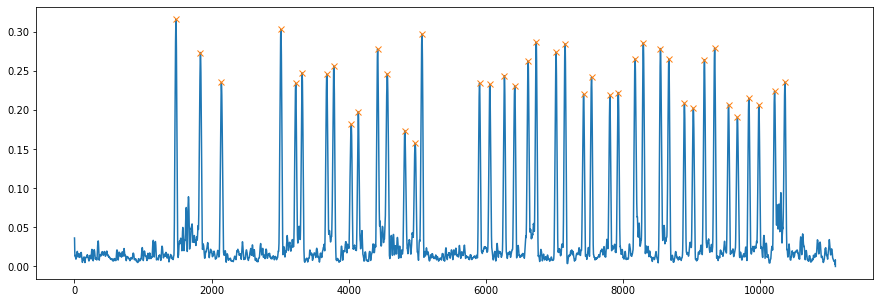

In [14]:
mav, mmd, auto_bins, peaks = find_letters_range(y_test_proba)

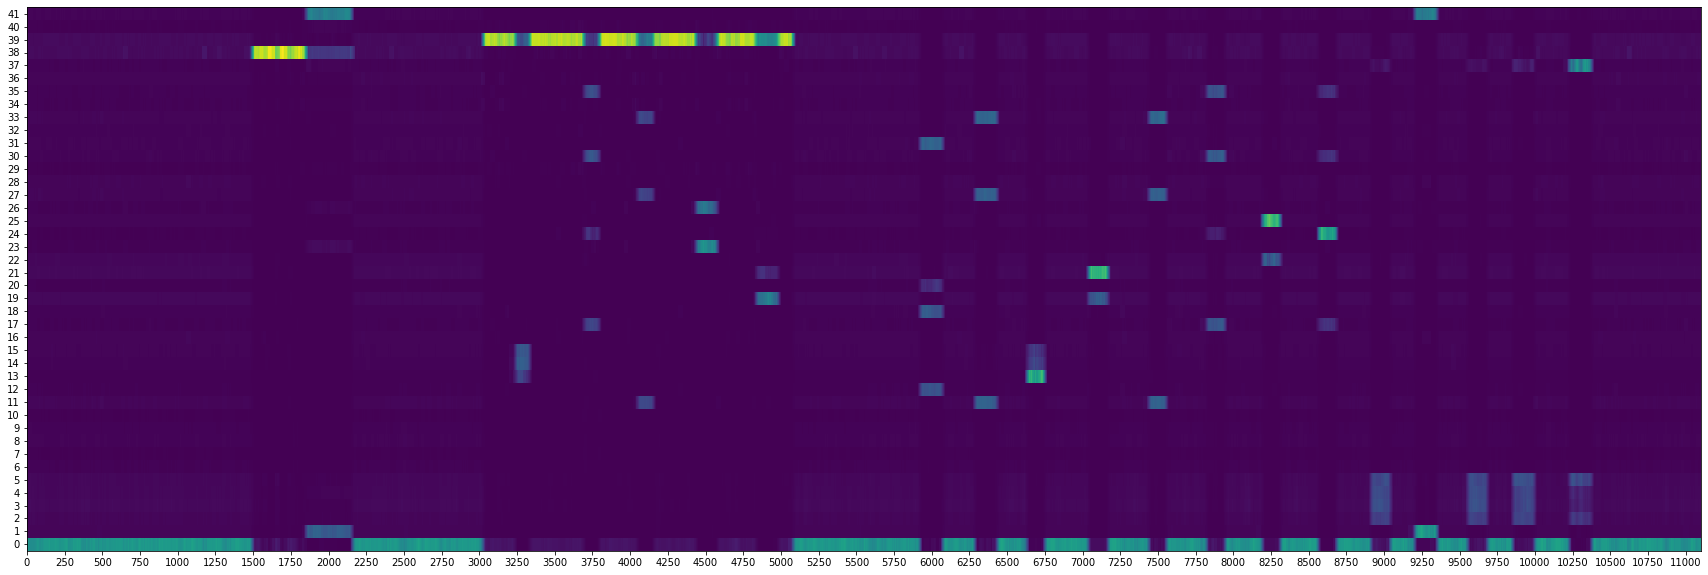

In [15]:
plot_moving_average(mav,)

## Remarque

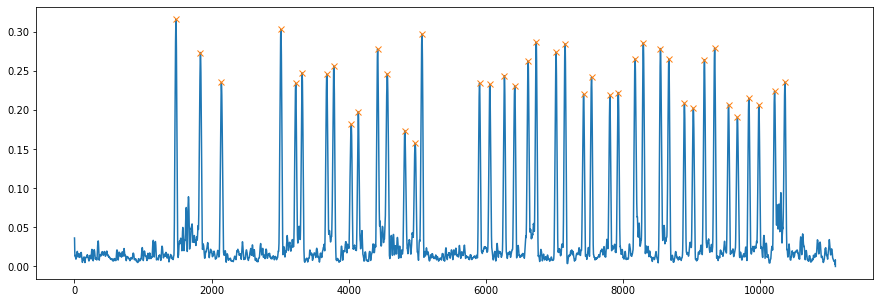

In [16]:
peaks, _ = find_peaks(mmd, height=0.15, distance=10)
plt.figure(figsize = (15,5))
plt.plot(mmd)
plt.plot(peaks, mmd[peaks], "x")
plt.show()

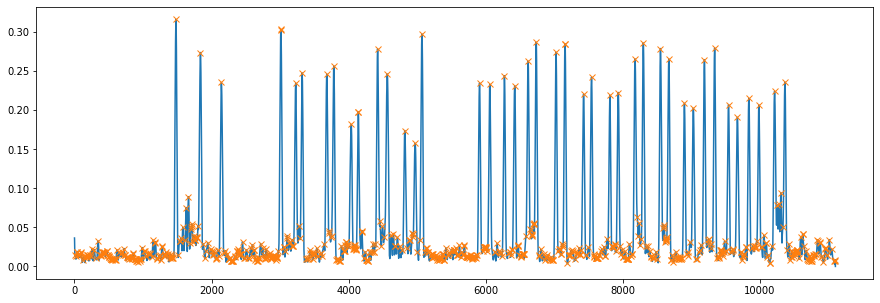

In [17]:
peaks_all, _ = find_peaks(mmd)
plt.figure(figsize = (15,5))
plt.plot(mmd)
plt.plot(peaks_all, mmd[peaks_all], "x")
plt.show()



Ici, on place nous même un threshold "d'acceptation" des pics. En réalité il serait aisé de mettre un place un petit système de clustering automatique en tre les pics "de bruit" et les pics qui nous intéressent vraiment.

On peut faire varier la taille de la fenêtre à la main, en fonction du bruit dans le signal. C'est un tradeoff à trouver entre élimination du bruit et finesse des pics de séparation entre les différentes touches pressées. On peut alors faire face a des phénomènes de recouvrement qui, suivant la taille minimale des appuyes touche, seront plus ou moins problématiques.


## Clustering des pics pour trouver les indices de deverouillage, login et mdp

In [18]:
def get_split_login_mdp(peaks, mmd, is_plot = True ) : 
  ''' Return indexes of unlocking, login and mdp '''
  a = [[peaks[i], mmd[peaks[i]]] for i in range(len(peaks)) ]
  b = [[i, mmd[i]] for i in range(len(mmd))]

  model=AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single').fit(a)
  peaks_pred = model.fit_predict(a)

  if is_plot : 
    plt.subplots(figsize = (14,10))
    plt.plot(mmd)
    colors = ['r','b','g']
    for i,center in enumerate(peaks_pred) :
      plt.xlabel('Trames')
      plt.ylabel('Distance moyenne des vecteurs de probabilité des trames')
      plt.scatter(a[i][0], a[i][1],color =  colors[center])
    

  return peaks_pred

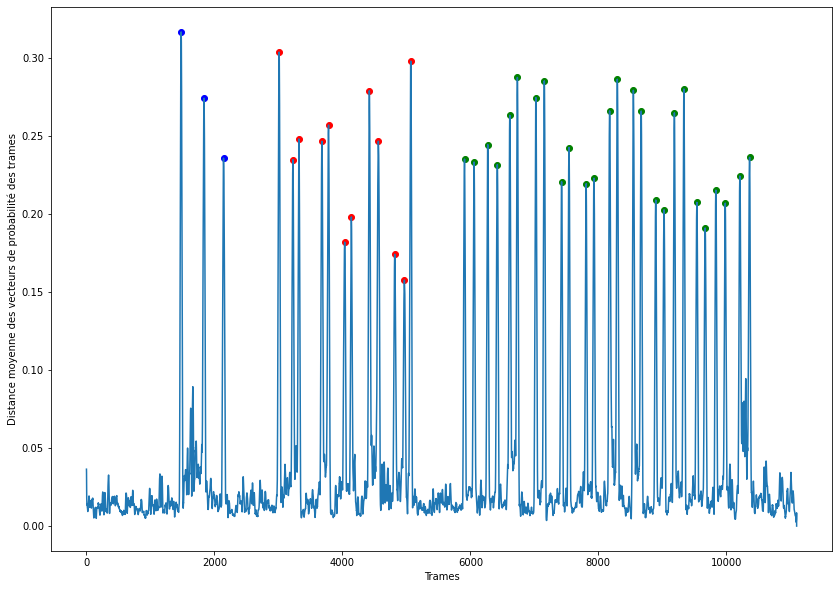

In [19]:
peaks_pred = get_split_login_mdp(peaks, mmd, is_plot= True)

- On remarque les différentes classes : une classe pour le déverouillage, une pour le login et une pour le mdp

In [20]:
peaks_pred

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Retourne l'indice des trames pour le login et mdp 

In [21]:
indexes_trames = get_indexes_trames(auto_bins, peaks_pred, peaks)

## Recuperation des combinaisons de mots 

In [22]:
analyser.bins = get_distance_bins(peaks)

In [23]:
mdp= analyser.decode_mdp(5)

In [24]:
def get_distance_mdp(mdp) : 
  ''' Plot the distance between words '''
  SHIFT_color = 'm'
  CTRL_color = 'orange'
  SUPPR_color = 'red'
  NOKEY_color = 'darkgray'
  ENTER_color = 'lime'
  SPACE_color = 'salmon'


  infos=[]
  t=[]
  l=[]
  colors=[]
  for letterNum in range(len(mdp)):
      
      labels = mdp[letterNum][0]
      
      if mdp[letterNum][1][0]==0:
          likelihood = [1] + [0]*(len(mdp[letterNum][1])-1)
      else:
          likelihood = ((np.array(mdp[letterNum][1]))).tolist()
          
      infos.append([labels,likelihood])
      t+= [letterNum+1]*len(mdp[letterNum][0])
      l+= likelihood
      for label in labels:
          if label == 'SHIFT':
              colors.append(SHIFT_color)
          elif label == 'CTRL':
              colors.append(CTRL_color)
          elif label == 'SPACE':
              colors.append(SPACE_color)
          elif label == 'SUPPR':
              colors.append(SUPPR_color)
          elif label == 'ENTER':
              colors.append(ENTER_color)
          elif label == 'NOKEY':
              colors.append(NOKEY_color)
          else:
              colors.append('black')
              
  fig, ax = plt.subplots(figsize=(17,10))

  ax.set_yscale('log')
  ax.set_xlabel('Numéro de touche pressé')
  ax.set_ylabel('Distance par rapport aux touches connues')
  ax.scatter(t, l, c=colors)



  for letterNum, info in enumerate(infos):
      labels=info[0]
      likelihood=info[1]
      for i in range(len(labels)):
          if i%2==0:
              ax.annotate(labels[i][:2], (letterNum+1.2, likelihood[i]))
          else :
              ax.annotate(labels[i][:2], (letterNum+0.4 -(len(labels[i][:2])-1)*0.3 , likelihood[i]))



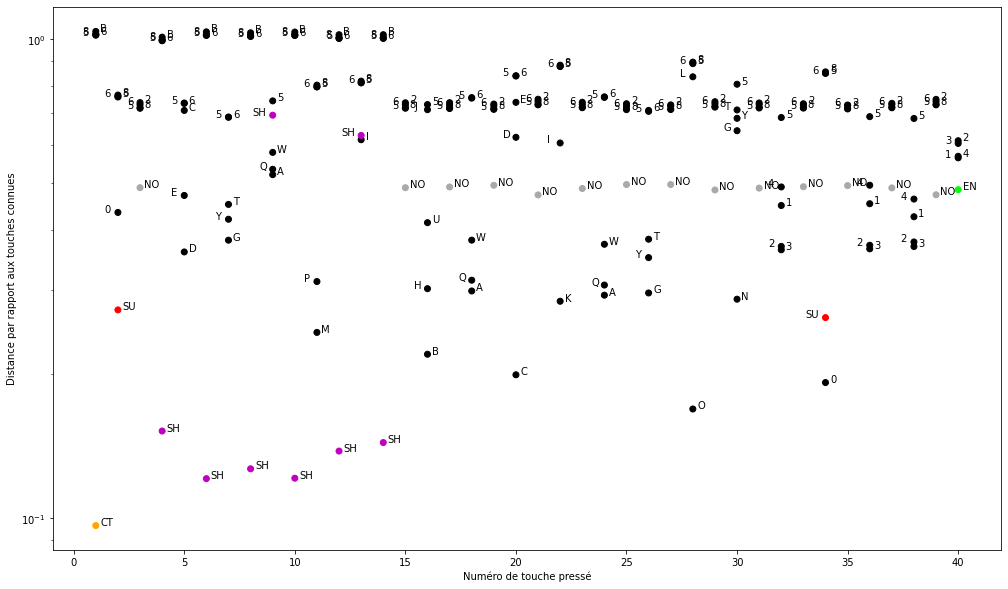

In [25]:
get_distance_mdp(mdp)

In [26]:
def read_word(word):
    out=''
    maj=False
    plus=''
    for key in word:
        if key=='SHIFT':
            maj=True
        elif key=='NOKEY':
            maj=False
        elif key == 'CTRL':
            out += plus + 'CTRL'
            plus='+'
        elif key == 'SUPPR':
            out += plus + 'SUPPR'
            plus='+'
        elif key == 'ENTER':
            out += plus + 'ENTER'
            plus='+'
        elif key == 'SPACE':
            out += plus + 'SPACE'
            plus='+'
        else:
            if maj:
                out+= plus + key
                plus=''
            else:
                out+= plus + key.lower()
                plus=''
    return out


Le paramètre "bonus" varie entre 0 et 1. A bonus=0, le prédicteur minimise la somme des distances entre 
les vecteurs de probabilités référents pour les classes (issus de la confusion matrix) et les vecteurs de proba 
des touches pressés. A bonus=1, le prédicteur de mot cherche à minimiser les distances parcourus par les nouveaux vecteurs de probabilité et l'original. 


In [27]:
def get_most_probable_words(mdp,mouvs=5,bonus=0.9):
    ''' 
    mouvs : Nombre de lettres qu on s autorise à changer dans les mots générés  
    '''
    next_position=np.ones((len(mdp),),dtype='int64')
    tested_mouvs=[]
    tested_words=[[mdp[i][0][0] for i in range(len(mdp))]]

    for mouv in range(mouvs):
        min_next_mouv_size = mdp[1][1][next_position[1]]  -  mdp[1][1][0]*bonus
        min_next_mouv_index = 1
        for i in range(len(mdp)):
            if next_position[i]<len(mdp[i][1]):
                next_mouv_size =  mdp[i][1][next_position[i]] -  mdp[i][1][0]*bonus
                if next_mouv_size < min_next_mouv_size:
                    min_next_mouv_size = next_mouv_size
                    min_next_mouv_index = i

        next_mouved_letter = min_next_mouv_index
        move_position = next_position[next_mouved_letter]

        tested_mouvs.append(next_mouved_letter)
        
        new_words=[]
        for word in tested_words:
            new_word = word.copy()
            new_word[next_mouved_letter]=mdp[next_mouved_letter][0][move_position]
            new_words.append(new_word)
        tested_words = tested_words + new_words
        next_position[next_mouved_letter] = next_position[next_mouved_letter]+1
        npa = np.array(tested_words)

        
    return npa[np.sort(np.unique(npa, axis=0, return_index=True)[1])]

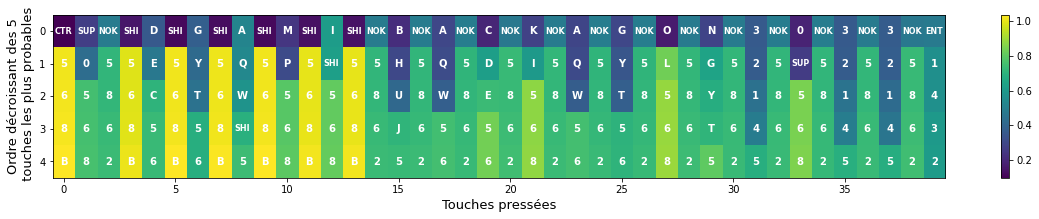

In [28]:
plot_probability_words(mdp)

In [29]:
def get_all_words(mdp,indexes_trames) : 
  ''' Return all the words probables for login and mdp '''
  output = {'login' : [], 'mdp' : []}
  for name in output : 
    indexes = indexes_trames[name]
    words = get_most_probable_words(mdp[indexes[0]: indexes[1]],15)
    r_words = []
    for word in words:
        r_words.append(read_word(word))
    output[name].extend(r_words)

  return output

In [30]:
output_pred = get_all_words(mdp , indexes_trames)

In [31]:
login = pd.DataFrame(output_pred['login'], columns = ['Login'])
mot_de_passe = pd.DataFrame(output_pred['mdp'], columns = ['Mdp'])

In [32]:
login.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
Login,DGAMI,DGQMI,DGAM,DGQM,DYAMI,DYQMI,DYAM,DYQM,DGAPI,DGQPI,DGAP,DGQP,DYAPI,DYQPI,DYAP,DYQP,DTAMI,DTQMI,DTAM,DTQM,DTAPI,DTQPI,DTAP,DTQP,DGWMI,DGWM,DYWMI,DYWM,DGWPI,DGWP,DYWPI,DYWP,DTWMI,DTWM,DTWPI,DTWP,EGAMI,EGQMI,EGAM,EGQM,...,ET5MI6,ET5M6,ET5PI6,ET5P6,DG5M56,DY5M56,DG5P56,DY5P56,DT5M56,DT5P56,EG5M56,EY5M56,EG5P56,EY5P56,ET5M56,ET5P56,DG5M66,DY5M66,DG5P66,DY5P66,DT5M66,DT5P66,EG5M66,EY5M66,EG5P66,EY5P66,ET5M66,ET5P66,DG5M86,DY5M86,DG5P86,DY5P86,DT5M86,DT5P86,EG5M86,EY5M86,EG5P86,EY5P86,ET5M86,ET5P86


In [33]:
mot_de_passe.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3848,3849,3850,3851,3852,3853,3854,3855,3856,3857,3858,3859,3860,3861,3862,3863,3864,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887
Mdp,backagon3033,backagon2033,backagon3023,backagon2023,backqgon3033,backqgon2033,backqgon3023,backqgon2023,backagon3032,backagon2032,backagon3022,backagon2022,backqgon3032,backqgon2032,backqgon3022,backqgon2022,bqckagon3033,bqckagon2033,bqckagon3023,bqckagon2023,bqckqgon3033,bqckqgon2033,bqckqgon3023,bqckqgon2023,bqckagon3032,bqckagon2032,bqckagon3022,bqckagon2022,bqckqgon3032,bqckqgon2032,bqckqgon3022,bqckqgon2022,backayon3033,backayon2033,backayon3023,backayon2023,backqyon3033,backqyon2033,backqyon3023,backqyon2023,...,hwckwgon1014,hwckwyon1014,hwckwgon1SUPPR+14,hwckwyon1SUPPR+14,backaton1014,backqton1014,bqckaton1014,bqckqton1014,backaton1SUPPR+14,backqton1SUPPR+14,bqckaton1SUPPR+14,bqckqton1SUPPR+14,hackaton1014,hackqton1014,hqckaton1014,hqckqton1014,hackaton1SUPPR+14,hackqton1SUPPR+14,hqckaton1SUPPR+14,hqckqton1SUPPR+14,backwton1014,bqckwton1014,backwton1SUPPR+14,bqckwton1SUPPR+14,hackwton1014,hqckwton1014,hackwton1SUPPR+14,hqckwton1SUPPR+14,bwckaton1014,bwckqton1014,bwckaton1SUPPR+14,bwckqton1SUPPR+14,hwckaton1014,hwckqton1014,hwckaton1SUPPR+14,hwckqton1SUPPR+14,bwckwton1014,bwckwton1SUPPR+14,hwckwton1014,hwckwton1SUPPR+14


In [34]:
login.to_csv('login.csv')
mot_de_passe.to_csv('mdp.csv')

# Conclusion 

- Notre méthode permet de dire que le premier mot que nous trouvons pour le login est : **DGAMI**
- Le mot de passe est parmi 3888 propositions : nous pensons que c'est **hackaton2021**